In [4]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 189 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 


In [5]:
import fastai
from fastai.tabular.all import *
import ipywidgets as widgets

In [6]:
 #path = "/content/combined_eight_seasons_data_withOdds.csv"
path = "/content/combined_eight_seasons_data.csv"
# path = "/content/combined_five_seasons_data.csv"

Then we can have a look at how the data is structured:

In [9]:
df = pd.read_csv(path)
df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,ScoreDiff,HomeWinStreak,AwayWinStreak,TGSH,TGSA,Results,Referee
0,Arsenal,Crystal Palace,2,1,1,1,0,0,0,Win,J Moss
1,Leicester,Everton,2,2,0,1,0,0,0,Draw,M Jones
2,Man United,Swansea,1,2,-1,0,1,0,0,Loss,M Dean
3,QPR,Hull,0,1,-1,0,2,0,0,Loss,C Pawson
4,Stoke,Aston Villa,0,1,-1,0,3,0,1,Loss,A Taylor


In [ ]:
# without Odds
dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
    cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA', 'Referee'],
    cont_names = ['HomeWinStreak', 'AwayWinStreak'],
    procs = [Categorify, FillMissing, Normalize])

# # with Odds
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA', 'Referee'],
#     cont_names = ['HomeWinStreak', 'AwayWinStreak', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA' ],
#     procs = [Categorify, FillMissing, Normalize])

# # with Only Odds
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam'],
#     cont_names = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA' ],
#     procs = [Categorify, FillMissing, Normalize])

# # with Only Odds from B365
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam'],
#     cont_names = ['B365H', 'B365D', 'B365A'],
#     procs = [Categorify, FillMissing, Normalize])

# # with Only Odds from BWA
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam'],
#     cont_names = ['BWH', 'BWD', 'BWA'],
#     procs = [Categorify, FillMissing, Normalize])

The last part is the list of pre-processors we apply to our data:

- `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
- `FillMissing` will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
- `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)



In [10]:
splits = EndSplitter(valid_pct=0.1, valid_last=True)(range_of(df))

In [11]:
# without Odds
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA', 'Referee'],
                   cont_names = ['HomeWinStreak', 'AwayWinStreak'],
                   y_names='Results',
                   splits=splits)

# # with Odds
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA', 'Referee'],
#                    cont_names = ['HomeWinStreak', 'AwayWinStreak', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA' ],
#                    y_names='Results',
#                    splits=splits)

# # with ONLY Odds
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam'],
#                    cont_names = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA'],
#                    y_names='Results',
#                    splits=splits)

# # with ONLY Odds from B365
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam'],
#                    cont_names = ['B365H', 'B365D', 'B365A'],
#                    y_names='Results',
#                    splits=splits)

# # with ONLY Odds from BW
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam'],
#                    cont_names = ['BWH', 'BWD', 'BWA'],
#                    y_names='Results',
#                    splits=splits)

Once we build our `TabularPandas` object, our data is completely preprocessed as seen below:

In [12]:
to.xs.iloc[:2]

,HomeTeam,AwayTeam,TGSH,TGSA,Referee,HomeWinStreak,AwayWinStreak
0,1,9,1,1,11,-0.247341,-0.629619
1,15,10,1,1,19,-0.247341,-0.629619


Now we can build our `DataLoaders` again:

In [13]:
dls = to.dataloaders(bs=64)

> Later we will explore why using `TabularPandas` to preprocess will be valuable.

The `show_batch` method works like for every other application:

In [14]:
dls.show_batch()

,HomeTeam,AwayTeam,TGSH,TGSA,Referee,HomeWinStreak,AwayWinStreak,Results
0,Arsenal,Leicester,0,0,C Kavanagh,2.000000e+00,9.613172e-09,Win
1,Liverpool,Aston Villa,0,0,J Moss,1.000000e+00,9.613172e-09,Win
2,Everton,Huddersfield,0,0,C Kavanagh,2.000000e+00,9.613172e-09,Win
3,West Brom,Man United,0,0,M Dean,1.000000e+00,9.613172e-09,Draw
4,Tottenham,West Ham,0,0,C Pawson,2.000000e+00,9.613172e-09,Win
5,Bournemouth,Man City,0,0,R Madley,-2.287897e-08,2.000000e+00,Loss
6,Watford,Sheffield United,0,0,A Marriner,-2.287897e-08,1.000000e+00,Draw
7,Sunderland,Man City,0,0,S Attwell,-2.287897e-08,2.000000e+00,Loss
8,Bournemouth,Wolves,0,0,S Hooper,-2.287897e-08,2.000000e+00,Loss
9,Swansea,Liverpool,0,0,R East,-2.287897e-08,1.000000e+00,Loss


We can define a model using the `tabular_learner` method. When we define our model, `fastai` will try to infer the loss function based on our `y_names` earlier. 

**Note**: Sometimes with tabular data, your `y`'s may be encoded (such as 0 and 1). In such a case you should explicitly pass `y_block = CategoryBlock` in your constructor so `fastai` won't presume you are doing regression.

In [15]:
learn = tabular_learner(dls, metrics=accuracy)

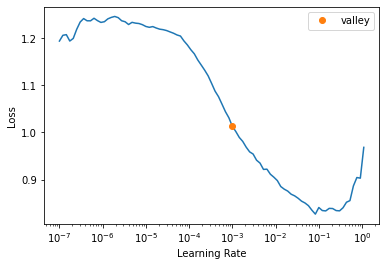

In [16]:
lr = learn.lr_find()

And we can train that model with the `fit_one_cycle` method (the `fine_tune` method won't be useful here since we don't have a pretrained model).

In [17]:
learn.fit_one_cycle(10, lr_max=slice(lr.valley))

epoch,train_loss,valid_loss,accuracy,time
0,0.789433,0.742037,0.769784,00:00
1,0.665810,0.594098,0.769784,00:00
2,0.612088,0.561600,0.776978,00:00
3,0.575886,0.540671,0.751799,00:00
4,0.548499,0.517051,0.766187,00:00
5,0.528493,0.517431,0.773381,00:00
6,0.510641,0.517373,0.762590,00:00
7,0.495401,0.521058,0.755396,00:00
8,0.486892,0.518979,0.751799,00:00
9,0.476065,0.517557,0.748201,00:00


We can then have a look at some predictions:

In [18]:
learn.show_results(max_n=5)

,HomeTeam,AwayTeam,TGSH,TGSA,Referee,HomeWinStreak,AwayWinStreak,Results,Results_pred
0,28.0,17.0,1.0,1.0,3.0,-0.247341,-0.629619,2.0,2.0
1,32.0,18.0,1.0,1.0,18.0,-0.788346,0.312558,1.0,1.0
2,27.0,25.0,2.0,1.0,20.0,0.834669,-0.629619,2.0,2.0
3,4.0,16.0,1.0,1.0,30.0,-0.788346,0.312558,0.0,1.0
4,5.0,20.0,1.0,1.0,7.0,-0.247341,-0.629619,0.0,2.0


Or use the predict method on a row:

In [ ]:
row, clas, probs = learn.predict(df.iloc[9])

In [ ]:
row.show()

,HomeTeam,AwayTeam,TGSH,TGSA,Referee,HomeWinStreak,AwayWinStreak,Results
0,Burnley,Chelsea,0,0,M Oliver,-2.287897e-08,2.0,Loss


In [ ]:
clas, probs

(tensor(1), tensor([0.1094, 0.8829, 0.0078]))

In [ ]:
# dfTest = pd.read_csv("/content/Test.csv")
# dfTest

In [ ]:
# row, clas, probs = learn.predict(dfTest.iloc[8])

In [ ]:
# clas, probs

In [ ]:
# test_df = dfTest.copy()
# test_df.drop(['Results'], axis=1, inplace=True)
# dl = learn.dls.test_dl(test_df)

In [ ]:
# learn.get_preds(dl=dl)

In [32]:
predict_input = df.iloc[9].copy()
predict_input = predict_input.drop(["ScoreDiff", "FTHG", "FTAG", "Results"])
predict_input

HomeTeam          Burnley
AwayTeam          Chelsea
HomeWinStreak           0
AwayWinStreak           2
TGSH                    0
TGSA                    0
Referee          M Oliver
Name: 9, dtype: object

In [34]:
type(predict_input["TGSH"])

float

In [20]:
home_team = widgets.Text(
    value='Home Team',
    placeholder='Type a Team',
    description='Home Team:',
    disabled=False
)
display(home_team)
predict_input["HomeTeam"] = home_team.value

Text(value='Home Team', description='Home Team:', placeholder='Type a Team')

In [21]:
away_team = widgets.Text(
    value='Away Team',
    placeholder='Type a Team',
    description='Away Team:',
    disabled=False
)
display(away_team)
# predict_input["AwayTeam"] = away_team.value

Text(value='Away Team', description='Away Team:', placeholder='Type a Team')

In [22]:
home_three = widgets.RadioButtons(
    options=[1.0, 0.0],
#    value='pineapple', # Defaults to 'pineapple'
 #   layout={'width': 'max-content'}, # If the items' names are long
    description='Home 3 Game win streak:',
    disabled=False
)
display(home_three)
# predict_input["TGSH"] = home_three.value

RadioButtons(description='Home 3 Game win streak:', options=(1.0, 0.0), value=1.0)

In [23]:
away_three = widgets.RadioButtons(
    options=[1.0, 0.0],
#    value='pineapple', # Defaults to 'pineapple'
   layout={'width': 'max-content'}, # If the items' names are long
    description='Away 3 Game win streak:',
    disabled=False
)
display(away_three)
# predict_input["TGSA"] = away_three.value

RadioButtons(description='Away 3 Game win streak:', layout=Layout(width='max-content'), options=(1.0, 0.0), va…

In [24]:
home_streak = widgets.FloatText(
    value= 2.0,
    description='Home Team Streak:',
)
display(home_streak)
# predict_input["HomeWinStreak"] = home_streak.value

FloatText(value=2.0, description='Home Team Streak:')

In [25]:
away_streak = widgets.FloatText(
    value= 1,
    description='Away Team Streak:',
)
display(away_streak)
# predict_input["AwayWinStreak"] = away_streak.value

FloatText(value=1.0, description='Away Team Streak:')

In [26]:
ref_text = widgets.Text(
    value='Enter Referee',
    placeholder='Enter Referee',
    description='Enter Referee',
    disabled=False
)
display(ref_text)

Text(value='Enter Referee', description='Enter Referee', placeholder='Enter Referee')

In [33]:
predict_input["HomeTeam"] = home_team.value
predict_input["AwayTeam"] = away_team.value
predict_input["TGSH"] = home_three.value
predict_input["TGSA"] = away_three.value
predict_input["AwayWinStreak"] = away_streak.value
predict_input["HomeWinStreak"] = home_streak.value
predict_input["Referee"] = ref_text.value
predict_input


HomeTeam          Chelsea
AwayTeam          Arsenal
HomeWinStreak           0
AwayWinStreak           0
TGSH                    0
TGSA                    0
Referee          M Oliver
Name: 9, dtype: object

In [34]:
row, clas, probs = learn.predict(predict_input)

In [35]:
probs

tensor([0.3540, 0.0610, 0.5850])

In [36]:
if torch.argmax(probs) == 0:
  print("Loss")
elif torch.argmax(probs) == 1:
  print("Draw")
else:
  print("Win")

Win
